<a href="https://colab.research.google.com/github/ashishakonnur/Stroke-Predicition/blob/main/Natural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/competitions/nlp-getting-started

## Introduction

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:





The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.




In [ ]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
# from nltk.tokenize import word_tokenize
# import gensim
# import string
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# from keras.models import Sequential
# from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
# from keras.initializers import Constant
# from sklearn.model_selection import train_test_split
# from keras.optimizers import Adam

In [ ]:
tweet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp-getting-started/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp-getting-started/test.csv')
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


There are 2 Classes of Distribution. Class 0 is No Disaster and Class 1 is Disaster.

# Exploratory Data Analysis of tweets

My goal here is to do some basis analysis of character level, word level and sentences analysis.

### Number of characters in a tweets

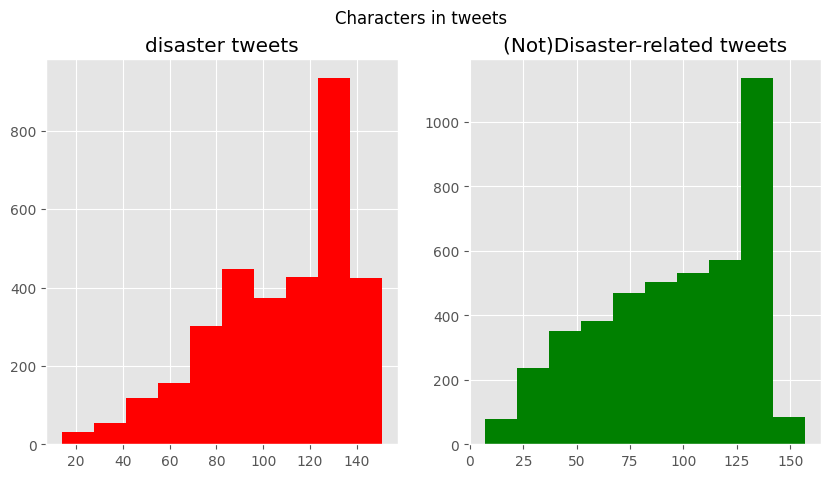

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

# Disaster
tweet_len = tweet[tweet['target'] == 1]['text'].str.len()
ax1.hist(tweet_len, color = 'red')
ax1.set_title('disaster tweets')

# Not a Disaster
tweet_len = tweet[tweet['target']== 0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('(Not)Disaster-related tweets')

fig.suptitle('Characters in tweets')
plt.show()

The distribution of both sets seems the same.

We learn that 120 to 140 characters in a tweet are the most common among both

### Number of words in a tweet

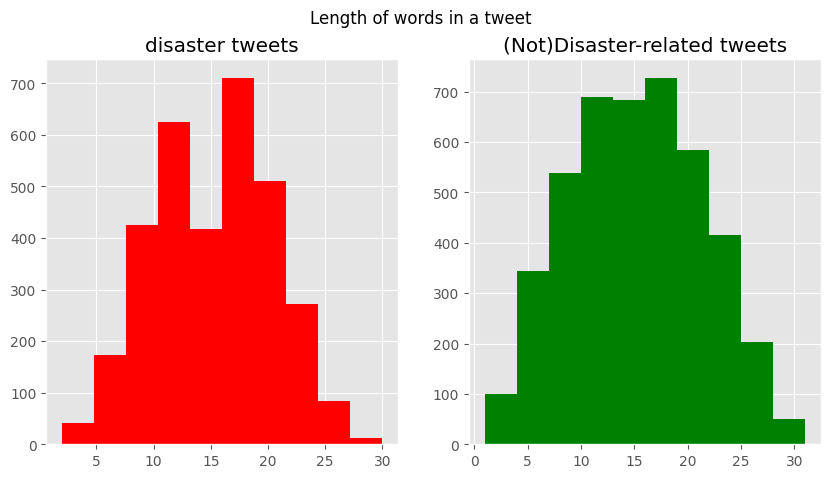

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tweet_len = tweet[tweet['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='red')
ax1.set_title('disaster tweets')

tweet_len = tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('(Not)Disaster-related tweets')

fig.suptitle('Length of words in a tweet')
plt.show()

Not very useful.. 10 to 20 words in a tweet

### Common stop words

<BarContainer object of 10 artists>

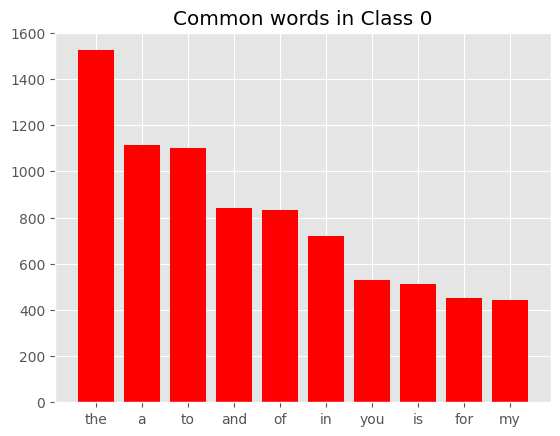

In [ ]:
# Create a function to count STOPWORDS (This is a list of lexical stop words in English.
# That is, these words are ignored during most natural language processing tasks,
# such as part-of-speech tagging, tokenization and parsing.)
def create_corpus(target):
    corpus=[]
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# Analyse tweets with class 0
corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
      if word in stop:
          dic[word]+=1

top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

x,y = zip(*top)
plt.title('Common words in Class 0')
plt.bar(x,y,color='red')

<BarContainer object of 10 artists>

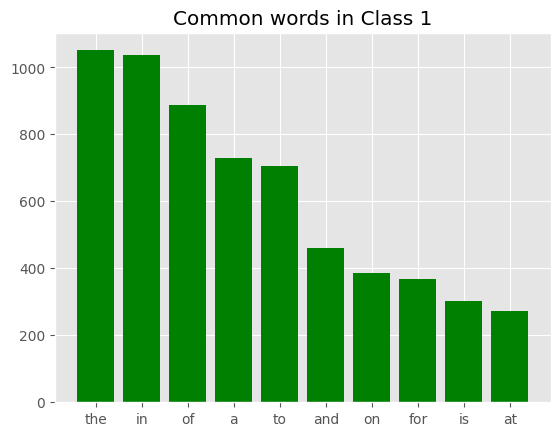

In [ ]:
# Analyse tweets with class 1
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

x,y=zip(*top)
plt.title('Common words in Class 1')
plt.bar(x,y,color='green')

### Punctuations

<BarContainer object of 18 artists>

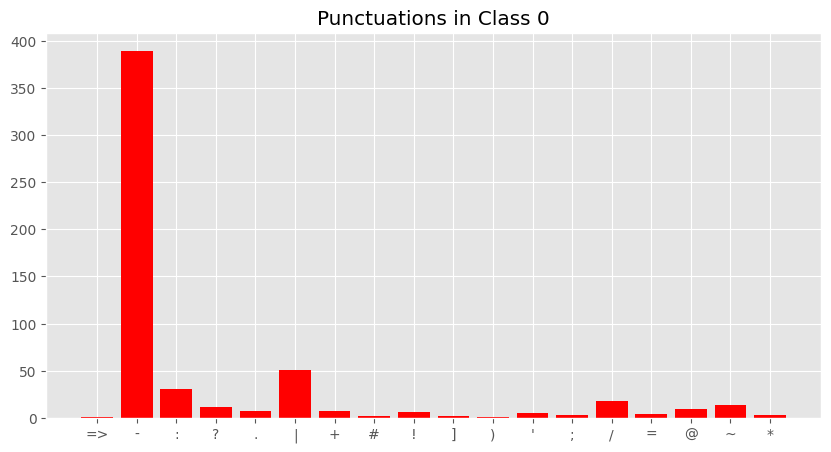

In [ ]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.title('Punctuations in Class 0')
plt.bar(x,y, color='red')

<BarContainer object of 20 artists>

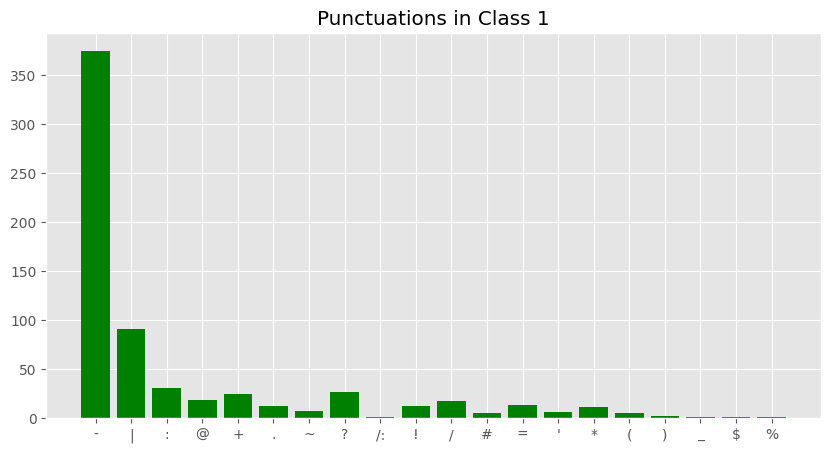

In [ ]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.title('Punctuations in Class 1')
plt.bar(x,y,color='green')

### Common words

<BarContainer object of 8 artists>

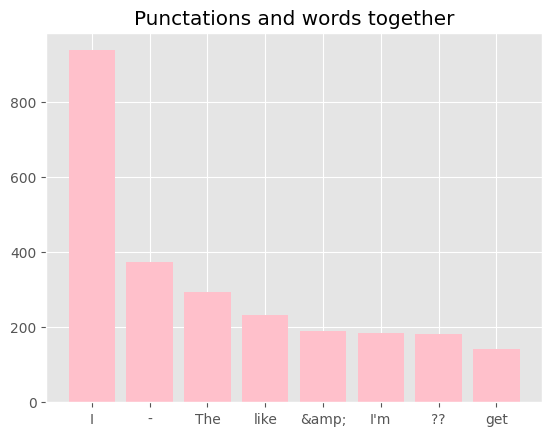

In [ ]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

plt.title('Punctations and words together')
plt.bar(x,y, color='pink')

## Data Cleaning


Now we know that twitter tweets have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction, removing punctuations, removing html tags and emojis etc.

## Removing URLs

We will combine the tweet and test dataset to apply similar treatment for the data cleaning.

In [ ]:
df = pd.concat([tweet,test])
df.shape

(10876, 5)

In [ ]:
def remove_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)

df['text'] = df['text'].apply(lambda x : remove_URL(x))

**Removing HTML tags**

In [ ]:
def remove_html(text):
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)

df['text'] = df['text'].apply(lambda x : remove_html(x))

**Removing EMOJI's tags**

In [ ]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x: remove_emoji(x))

**Removing punctuations**

In [ ]:
def remove_punct(text):
  punct = str.maketrans('', '', string.punctuation)
  return text.translate(punct)

df['text']=df['text'].apply(lambda x: remove_punct(x))

**Spelling Correction**

We will use pyspellchecker

In [ ]:
pip install pyspellchecker

In [ ]:
from spellchecker import SpellChecker

def correct_spelling(input_text):
    # Initialize the spellchecker
    spell = SpellChecker()

    # Split the input text into words
    words = input_text.split()

    # Initialize an empty list to store corrected words
    corrected_words = []

    # Iterate through the words
    for word in words:
        # Check if the word is misspelled
        if spell.unknown([word]):
            # Get the corrected version of the word
            corrected_word = spell.correction(word)
            corrected_words.append(corrected_word)
        else:
            corrected_words.append(word)

    # Join the corrected words back into a single string
    corrected_text = ' '.join(corrected_words)

    return corrected_text

# Testing
input_text = "I havee a speling probleb"
correct_spelling(input_text)

'I have a spelling problem'

In [ ]:
# df['text'] = df['text'].apply(lambda x: correct_spelling(x))

# Machine Learning

**Using [WordEmbedding](https://www.mygreatlearning.com/blog/word-embedding/#:~:text=GloVe%20(Global%20Vectors%20for%20Word,on%20the%20word%2Dcontext%20matrix.)**

- Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space. These are essential for solving most Natural language processing problems.





## GloVe

Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.

We will try 100 D here.

In [ ]:
# >>> import nltk
# >>> nltk.download()

In [ ]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Define a set of stopwords
stop = set(stopwords.words('english'))

def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower()
                 for word in word_tokenize(tweet)
                 if (word.isalpha() == 1) and (word not in stop)]
        corpus.append(words)
    return corpus


corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:02<00:00, 5243.00it/s]


In [ ]:

embedding_dict = {}

with open('/content/drive/MyDrive/nlp-getting-started/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.array([float(x) for x in values[1:]], dtype='float32')
        embedding_dict[word] = vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)

    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 435188.94it/s]


In [ ]:
tweet_pad[0][0:]

array([ 622, 5467,  738,  175,   80, 1805, 3529,   16,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Baseline Model with GloVe results

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           2034300   
                                                                 
 spatial_dropout1d_4 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2076605 (7.92 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 2034300 (7.76 MB)
_________________________________________________________________


In [ ]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


In [ ]:
history = model.fit(X_train, y_train, batch_size=4, epochs=15, validation_data=(X_test,y_test), verbose=2)

Epoch 1/15
1523/1523 - 104s - loss: 0.6902 - accuracy: 0.5673 - val_loss: 0.6713 - val_accuracy: 0.5817 - 104s/epoch - 68ms/step
Epoch 2/15
1523/1523 - 96s - loss: 0.5836 - accuracy: 0.7097 - val_loss: 0.5191 - val_accuracy: 0.7636 - 96s/epoch - 63ms/step
Epoch 3/15
1523/1523 - 117s - loss: 0.5361 - accuracy: 0.7511 - val_loss: 0.5055 - val_accuracy: 0.7689 - 117s/epoch - 77ms/step
Epoch 4/15
1523/1523 - 99s - loss: 0.5255 - accuracy: 0.7521 - val_loss: 0.4974 - val_accuracy: 0.7781 - 99s/epoch - 65ms/step
Epoch 5/15
1523/1523 - 106s - loss: 0.5170 - accuracy: 0.7640 - val_loss: 0.4919 - val_accuracy: 0.7741 - 106s/epoch - 70ms/step
Epoch 6/15
1523/1523 - 95s - loss: 0.5037 - accuracy: 0.7688 - val_loss: 0.4868 - val_accuracy: 0.7787 - 95s/epoch - 63ms/step
Epoch 7/15
1523/1523 - 98s - loss: 0.5045 - accuracy: 0.7693 - val_loss: 0.4825 - val_accuracy: 0.7728 - 98s/epoch - 64ms/step
Epoch 8/15
1523/1523 - 94s - loss: 0.4973 - accuracy: 0.7737 - val_loss: 0.4785 - val_accuracy: 0.7853 - 

In [ ]:
train_pred_GloVe = model.predict(train)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')

238/238 [==============================] - 4s 16ms/step
